# Install Libraries

In [ ]:
!pip install gluonts
!pip install mxnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 5.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49.1 MB 105 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import LabelEncoder
#from sklearn.preprocessing import RobustScaler
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx import Trainer
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.pandas import PandasDataset
from gluonts.mx.trainer.model_averaging import ModelAveraging, SelectNBestSoftmax, SelectNBestMean
from gluonts.mx.trainer.learning_rate_scheduler import LearningRateReduction

# Read files

In [ ]:
# upload the files to colab directory first
df_building = pd.read_csv("/content/UCD_electricity_buildings.csv")
df_building[:5]

,timestamp,electricity_consumption,building,light_lux,outside_temperature,relative_humidity,area,CO2e_emission,cost,normalized_electricity_consumption,normalized_cost,normalized_CO2e
0,2015-01-01 00:00:00,109.264999,Agriculture & Food Science Building Electricity,122.896355,11.715427,30.404237,10529,57.364125,16.225852,0.010378,0.001541,0.005448
1,2015-01-01 01:00:00,111.284996,Agriculture & Food Science Building Electricity,124.211668,12.003126,45.249629,10529,58.424623,16.525822,0.010569,0.001570,0.005549
2,2015-01-01 02:00:00,106.947498,Agriculture & Food Science Building Electricity,128.879084,12.578514,54.757489,10529,56.147437,15.881704,0.010157,0.001508,0.005333
3,2015-01-01 03:00:00,115.107498,Agriculture & Food Science Building Electricity,127.787912,12.857532,56.241366,10529,60.431437,17.093463,0.010932,0.001623,0.005740
4,2015-01-01 04:00:00,107.972498,Agriculture & Food Science Building Electricity,129.823078,13.270016,54.726522,10529,56.685561,16.033916,0.010255,0.001523,0.005384


In [ ]:
df_campus = pd.read_csv("/content/UCD_electricity_campus.csv")
df_campus[:5]

,timestamp,electricity_consumption,campus,light_lux,outside_temperature,relative_humidity,CO2e_emission,cost
0,2015-01-01 00:00:00,2402.0,Belfield,122.896355,11.715427,30.404237,1261.050,356.6970
1,2015-01-01 01:00:00,2377.0,Belfield,124.211668,12.003126,45.249629,1247.925,352.9845
2,2015-01-01 02:00:00,2371.0,Belfield,128.879084,12.578514,54.757489,1244.775,352.0935
3,2015-01-01 03:00:00,2387.0,Belfield,127.787912,12.857532,56.241366,1253.175,354.4695
4,2015-01-01 04:00:00,2460.0,Belfield,129.823078,13.270016,54.726522,1291.500,365.3100


# Main DataFrame Preprocessing

In [ ]:
df_building.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1155936 entries, 0 to 1155935
Data columns (total 12 columns):
 #   Column                              Non-Null Count    Dtype  
---  ------                              --------------    -----  
 0   timestamp                           1155936 non-null  object 
 1   electricity_consumption             1155936 non-null  float64
 2   building                            1155936 non-null  object 
 3   light_lux                           1138770 non-null  float64
 4   outside_temperature                 1140697 non-null  float64
 5   relative_humidity                   1140697 non-null  float64
 6   area                                1155936 non-null  int64  
 7   CO2e_emission                       1155936 non-null  float64
 8   cost                                1155936 non-null  float64
 9   normalized_electricity_consumption  1155936 non-null  float64
 10  normalized_cost                     1155936 non-null  float64
 11  normalized_

In [ ]:
df_building["timestamp"] = pd.to_datetime(df_building["timestamp"])
df_campus["timestamp"] = pd.to_datetime(df_campus["timestamp"])

In [ ]:
df_building = df_building.set_index("timestamp")
df_campus = df_campus.set_index("timestamp")

In [ ]:
# All buildings have the same length of data, so there's no need to refill the index
for i in df_building["building"].unique():
  print(i)
  print(len(df_building[df_building["building"]==i].index))

Agriculture & Food Science Building Electricity
66168
Computer Science Electricity
66168
Computer Centre
66168
Confucius Main Electricity
31080
Health Science Total Electricity
66168
James Joyce Library Building Net Meter
66168
Newman Building (Arts) Electricity
66168
Nova Total Electricity
66168
O'Reilly Hall Electricity
66168
Quinn School Electricity
66168
Sports Centre Electricity
66168
Student Centre Electricity
66168
Sutherland School of Law Electricity
66168
Blackrock Library Electricity
66168
Blackrock Restaurant Electricity
66168
East & West Hall Electricity
66168
Proby House Electricity
66168
MH Total Electricity
66168


In [ ]:
for i in df_campus["campus"].unique():
  print(i)
  print(len(df_campus[df_campus["campus"]==i].index))

Belfield
66168
Blackrock
66168


In [ ]:
"""
# Refill DatetimeIndex for DataFrame
df_list = []
new_index = pd.date_range("1/1/2011", end="7/20/2022", freq="1H")

for item_id, gdf in df.groupby("building"):
    dfs = gdf.reindex(new_index)
    dfs["campus"].fillna(method = "bfill", inplace = True)
    dfs["campus"].fillna(method = "ffill", inplace = True)
    dfs["longitude"].fillna(method = "bfill", inplace = True)
    dfs["longitude"].fillna(method = "ffill", inplace = True)
    dfs["latitude"].fillna(method = "bfill", inplace = True)
    dfs["latitude"].fillna(method = "ffill", inplace = True)
    dfs["building"].fillna(method = "bfill", inplace = True)
    dfs["building"].fillna(method = "ffill", inplace = True)
    df_list.append(dfs)

df = pd.concat(df_list)
"""

'\n# Refill DatetimeIndex for DataFrame\ndf_list = []\nnew_index = pd.date_range("1/1/2011", end="7/20/2022", freq="1H")\n\nfor item_id, gdf in df.groupby("building"):\n    dfs = gdf.reindex(new_index)\n    dfs["campus"].fillna(method = "bfill", inplace = True)\n    dfs["campus"].fillna(method = "ffill", inplace = True)\n    dfs["longitude"].fillna(method = "bfill", inplace = True)\n    dfs["longitude"].fillna(method = "ffill", inplace = True)\n    dfs["latitude"].fillna(method = "bfill", inplace = True)\n    dfs["latitude"].fillna(method = "ffill", inplace = True)\n    dfs["building"].fillna(method = "bfill", inplace = True)\n    dfs["building"].fillna(method = "ffill", inplace = True)\n    df_list.append(dfs)\n\ndf = pd.concat(df_list)\n'

Encode labels for categorical features

In [ ]:
encoders_building = {}

for col in ["building"]:
  unique_values = list(df_building[col].unique())
  le = LabelEncoder().fit(unique_values)
  encoders_building[col] = le
  df_building[col] = le.transform(df_building[[col]])

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
df_building[:5]

,electricity_consumption,building,light_lux,outside_temperature,relative_humidity,area,CO2e_emission,cost,normalized_electricity_consumption,normalized_cost,normalized_CO2e
timestamp,,,,,,,,,,,
2015-01-01 00:00:00,109.264999,0,122.896355,11.715427,30.404237,10529,57.364125,16.225852,0.010378,0.001541,0.005448
2015-01-01 01:00:00,111.284996,0,124.211668,12.003126,45.249629,10529,58.424623,16.525822,0.010569,0.001570,0.005549
2015-01-01 02:00:00,106.947498,0,128.879084,12.578514,54.757489,10529,56.147437,15.881704,0.010157,0.001508,0.005333
2015-01-01 03:00:00,115.107498,0,127.787912,12.857532,56.241366,10529,60.431437,17.093463,0.010932,0.001623,0.005740
2015-01-01 04:00:00,107.972498,0,129.823078,13.270016,54.726522,10529,56.685561,16.033916,0.010255,0.001523,0.005384


In [ ]:
encoders_campus = {}

for col in ["campus"]:
  unique_values = list(df_campus[col].unique())
  le = LabelEncoder().fit(unique_values)
  encoders_campus[col] = le
  df_campus[col] = le.transform(df_campus[[col]])

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
df_campus[:5]

,electricity_consumption,campus,light_lux,outside_temperature,relative_humidity,CO2e_emission,cost
timestamp,,,,,,,
2015-01-01 00:00:00,2402.0,0,122.896355,11.715427,30.404237,1261.050,356.6970
2015-01-01 01:00:00,2377.0,0,124.211668,12.003126,45.249629,1247.925,352.9845
2015-01-01 02:00:00,2371.0,0,128.879084,12.578514,54.757489,1244.775,352.0935
2015-01-01 03:00:00,2387.0,0,127.787912,12.857532,56.241366,1253.175,354.4695
2015-01-01 04:00:00,2460.0,0,129.823078,13.270016,54.726522,1291.500,365.3100


# Prepare Train & Validation & Test Sets

In [ ]:
df_building_train = df_building.copy(deep=True).loc[df_building.index < "2019-04-01"]
df_building_val = df_building.copy(deep=True).loc[(df_building.index >= "2019-04-01") & (df_building.index < "2020-11-01")]
df_building_test = df_building.copy(deep=True)

Use "building" column as unique identifier (item_id)

In [ ]:
ds_building_train = PandasDataset.from_long_dataframe(df_building_train, target="electricity_consumption", item_id="building")
ds_building_val = PandasDataset.from_long_dataframe(df_building_val, target="electricity_consumption", item_id="building")
ds_building_test = PandasDataset.from_long_dataframe(df_building_test, target="electricity_consumption", item_id="building")

In [ ]:
next(iter(ds_building_train))

{'item_id': 0,
 'start': Period('2015-01-01 00:00', 'H'),
 'target': array([109.265   , 111.284996, 106.947495, ...,  95.575   ,  97.16    ,
         95.9925  ], dtype=float32)}

In [ ]:
df_campus_train = df_campus.copy(deep=True).loc[df_campus.index < "2019-04-01"]
df_campus_val = df_campus.copy(deep=True).loc[(df_campus.index >= "2019-04-01") & (df_campus.index < "2020-11-01")]
df_campus_test = df_campus.copy(deep=True)

Use "campus" column as unique identifier (item_id)

In [ ]:
ds_campus_train = PandasDataset.from_long_dataframe(df_campus_train, target="electricity_consumption", item_id="campus")
ds_campus_val = PandasDataset.from_long_dataframe(df_campus_val, target="electricity_consumption", item_id="campus")
ds_campus_test = PandasDataset.from_long_dataframe(df_campus_test, target="electricity_consumption", item_id="campus")

In [ ]:
next(iter(ds_campus_train))

{'item_id': 0,
 'start': Period('2015-01-01 00:00', 'H'),
 'target': array([2402., 2377., 2371., ..., 2422., 2545., 2476.], dtype=float32)}

# Model Configuration

In [ ]:
freq = "H"
prediction_length = 24*30*3

callbacks = [
    LearningRateReduction(objective="min",
               patience=10,
               base_lr=1e-2,
               decay_factor=0.5,
               ),
    ModelAveraging(avg_strategy=SelectNBestMean(num_models=2))
]

# Trainer parameters
epochs = 10
learning_rate = 1E-2
batch_size = 128
num_batches_per_epoch = 100
#clip_gradient = 5.4848
#weight_decay = 0.001

trainer = Trainer(ctx="cpu",
          epochs=epochs,
          learning_rate=learning_rate,
          hybridize=True,
          batch_size=batch_size,
          num_batches_per_epoch=num_batches_per_epoch,
          callbacks=callbacks
          )

# DeepAR Modeling

In [ ]:
# Deep AR 

# create estimator
deepar_estimator = DeepAREstimator(freq=freq, 
              context_length=prediction_length,
              prediction_length=prediction_length,
              use_feat_static_cat=False,
              use_feat_dynamic_real=False,
              cardinality=None,
              num_layers=2,
              num_cells=32,
              cell_type='lstm',
              scaling=True,
              #dropout_rate=0.1,
              trainer=trainer
              )

In [ ]:
deepar_predictor_building = deepar_estimator.train(training_data = ds_building_train, validation_data = ds_building_val)

100%|██████████| 100/100 [26:30<00:00, 15.90s/it, epoch=1/10, avg_epoch_loss=3.75]
1it [02:55, 175.70s/it, epoch=1/10, validation_avg_epoch_loss=2.69]
100%|██████████| 100/100 [16:57<00:00, 10.17s/it, epoch=2/10, avg_epoch_loss=2.93]
1it [02:45, 165.40s/it, epoch=2/10, validation_avg_epoch_loss=2.28]
100%|██████████| 100/100 [16:00<00:00,  9.60s/it, epoch=3/10, avg_epoch_loss=2.72]
1it [02:41, 161.77s/it, epoch=3/10, validation_avg_epoch_loss=2.29]
100%|██████████| 100/100 [16:30<00:00,  9.90s/it, epoch=4/10, avg_epoch_loss=2.59]
1it [04:37, 277.86s/it, epoch=4/10, validation_avg_epoch_loss=2.36]
100%|██████████| 100/100 [19:13<00:00, 11.53s/it, epoch=5/10, avg_epoch_loss=2.61]
1it [04:05, 245.58s/it, epoch=5/10, validation_avg_epoch_loss=2.23]
100%|██████████| 100/100 [18:44<00:00, 11.24s/it, epoch=6/10, avg_epoch_loss=2.53]
1it [03:46, 226.11s/it, epoch=6/10, validation_avg_epoch_loss=2.12]
100%|██████████| 100/100 [19:32<00:00, 11.72s/it, epoch=7/10, avg_epoch_loss=2.5]
1it [03:58, 

In [ ]:
deepar_predictor_campus = deepar_estimator.train(training_data = ds_campus_train, validation_data = ds_campus_val)

100%|██████████| 100/100 [26:49<00:00, 16.09s/it, epoch=1/10, avg_epoch_loss=6.29]
1it [05:12, 312.90s/it, epoch=1/10, validation_avg_epoch_loss=5.46]
100%|██████████| 100/100 [20:39<00:00, 12.39s/it, epoch=2/10, avg_epoch_loss=5.51]
1it [03:34, 214.38s/it, epoch=2/10, validation_avg_epoch_loss=5.31]
100%|██████████| 100/100 [20:00<00:00, 12.00s/it, epoch=3/10, avg_epoch_loss=5.28]
1it [04:06, 246.63s/it, epoch=3/10, validation_avg_epoch_loss=5.22]
100%|██████████| 100/100 [20:59<00:00, 12.60s/it, epoch=4/10, avg_epoch_loss=5.19]
1it [04:02, 242.60s/it, epoch=4/10, validation_avg_epoch_loss=5.17]
100%|██████████| 100/100 [20:17<00:00, 12.18s/it, epoch=5/10, avg_epoch_loss=5.14]
1it [04:09, 249.69s/it, epoch=5/10, validation_avg_epoch_loss=5.23]
100%|██████████| 100/100 [19:33<00:00, 11.74s/it, epoch=6/10, avg_epoch_loss=5.11]
1it [03:42, 222.08s/it, epoch=6/10, validation_avg_epoch_loss=5.08]
100%|██████████| 100/100 [19:14<00:00, 11.54s/it, epoch=7/10, avg_epoch_loss=5.09]
1it [04:22,

# DeepAR Evaluation

In [ ]:
deepar_forecast_it, deepar_ts_it = make_evaluation_predictions(
        dataset=ds_building_test,  # test dataset
        predictor=deepar_predictor_building,  # predictor
)

forecasts = list(deepar_forecast_it)
tss = list(deepar_ts_it)

In [ ]:
deepar_evaluator = Evaluator(quantiles=[0.25, 0.5, 0.75])
deepar_agg_metrics, deepar_item_metrics = deepar_evaluator(iter(tss), iter(forecasts), num_series=len(ds_building_test))

Running evaluation: 100%|██████████| 14/14 [00:00<00:00, 64.92it/s]


Agrregated Metrics

In [ ]:
deepar_agg_metrics

{'Coverage[0.25]': 0.15095899470899468,
 'Coverage[0.5]': 0.29305555555555557,
 'Coverage[0.75]': 0.5264550264550264,
 'MAE_Coverage': 0.17651014109347443,
 'MAPE': 0.32773032455848,
 'MASE': 1.6179612686936395,
 'MSE': 805.2586419322504,
 'MSIS': 10.052491201204592,
 'ND': 0.4190732322710233,
 'NRMSE': 0.6817254662065738,
 'OWA': nan,
 'QuantileLoss[0.25]': 466411.64956403617,
 'QuantileLoss[0.5]': 527509.0236945888,
 'QuantileLoss[0.75]': 402052.8937907219,
 'RMSE': 28.377079517319086,
 'abs_error': 527509.017578125,
 'abs_target_mean': 41.62537696475075,
 'abs_target_sum': 1258751.3994140625,
 'mean_absolute_QuantileLoss': 465324.5223497823,
 'mean_wQuantileLoss': 0.3696715034965496,
 'sMAPE': 0.697153521340991,
 'seasonal_error': 12.591622572692694,
 'wQuantileLoss[0.25]': 0.37053515871453774,
 'wQuantileLoss[0.5]': 0.4190732371301748,
 'wQuantileLoss[0.75]': 0.3194061146449362}

Metrics for each item_id

In [ ]:
deepar_item_metrics

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,ND,MSIS,QuantileLoss[0.25],Coverage[0.25],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.75],Coverage[0.75]
0,0.0,1935.015972,68635.625000,199416.125000,92.322280,21.568711,1.473234,0.172008,0.495810,0.344183,7.853173,65764.763054,0.178704,68635.624420,0.314352,50462.796093,0.492130
1,1.0,21.611811,6523.075195,10390.354492,4.810349,2.640270,1.143801,0.439989,0.650538,0.627801,17.713073,4316.842771,0.003241,6523.075409,0.134722,7635.871706,0.473148
2,2.0,471.631713,33831.710938,110422.968750,51.121745,4.999701,3.132753,0.151823,0.473701,0.306383,16.816105,35993.455311,0.169444,33831.712208,0.200000,19356.999338,0.517593
3,3.0,148.084057,20557.292969,49339.531250,22.842376,4.961767,1.918120,0.267435,0.603081,0.416650,8.640351,18740.815281,0.169444,20557.294326,0.211574,15075.686905,0.399537
4,4.0,18.485073,8725.731445,12919.685547,5.981336,1.698250,2.378737,0.636169,1.220323,0.675383,8.826483,6287.603031,0.053704,8725.731697,0.183333,6369.369650,0.256944
5,5.0,2599.406944,75780.070312,188766.546875,87.391920,33.639371,1.042926,0.207425,0.542671,0.401449,5.961712,70444.123483,0.168519,75780.070408,0.315741,58066.009811,0.639352
6,6.0,2429.449769,85265.468750,180992.218750,83.792694,12.962685,3.045261,0.320004,0.616555,0.471100,14.310617,67682.887458,0.298148,85265.468529,0.555093,61275.833988,0.658333
7,7.0,1555.320139,57864.921875,159726.296875,73.947360,27.063850,0.989856,0.172373,0.501767,0.362275,5.497924,55547.924779,0.171296,57864.922508,0.304167,41470.353516,0.653241
8,8.0,171.652517,21186.878906,43253.625000,20.024826,5.729654,1.711926,0.332025,0.685131,0.489829,9.675039,17617.220881,0.164815,21186.880270,0.192130,18091.518820,0.342593
9,9.0,488.788310,32939.671875,36486.046875,16.891688,10.680455,1.427828,0.809438,1.559426,0.902802,20.248315,18771.841615,0.038889,32939.673556,0.144907,37061.755039,0.266204


Draw time-series plots for random item_id

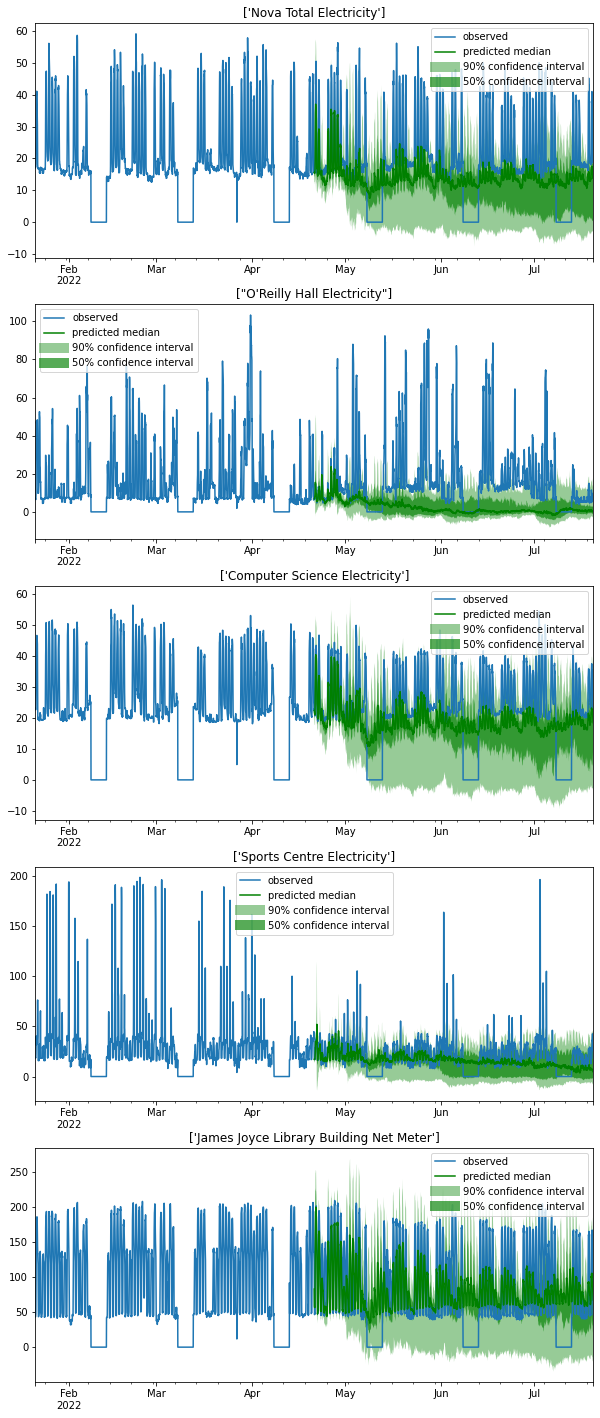

In [ ]:
n_plot = 5
indices = np.random.choice(np.arange(0, 18, 1), size=n_plot, replace=False)

fig, axes = plt.subplots(n_plot, 1, figsize=(10, n_plot*5))
for index, ax in zip(indices, axes):
    tss[index][-24*30*6:].plot(ax=ax)
    plt.sca(ax)
    forecasts[index].plot(color='g')
    name = encoders_building.get("building").inverse_transform([index])
    plt.title("{}".format(name))
    plt.legend(["observed", "predicted median", "90% confidence interval", "50% confidence interval"])

# DeepAR Prediction

In [ ]:
predictions_building = list(deepar_predictor_building.predict(ds_building_test))

In [ ]:
def sample_df(forecast):
  samples = forecast.samples
  dates = pd.date_range("2022-07-20 00:00", periods = 24*30*3, freq="H")
  return pd.DataFrame(samples.T, index=dates)

parts = [sample_df(entry).assign(entry=i) for i, entry in enumerate(predictions_building)]
predictions_building = pd.concat(parts)

In [ ]:
predictions_building[:5]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,entry
2022-07-20 00:00:00,89.980637,96.240532,92.752724,94.333496,90.132530,89.719749,95.235672,91.658424,95.286827,93.537582,89.640259,94.246506,94.445358,96.959198,90.495384,95.360687,90.906731,97.113274,95.512825,95.556137,92.411453,90.261810,98.755165,84.561661,93.575157,93.348145,89.976089,91.069550,91.537819,93.113571,92.650497,86.038918,94.034950,90.578697,94.221146,101.735382,96.230011,92.591553,97.744568,92.810844,95.428307,97.894630,91.270905,92.690193,90.798531,90.345795,91.159912,92.040146,84.094696,90.895210,95.642906,93.739838,101.761192,97.868736,89.285591,90.831688,92.139008,97.839340,90.860840,93.898773,89.348198,91.945480,92.955574,95.987526,93.393509,93.866394,86.389915,96.821274,88.986839,91.278687,93.409843,93.701942,91.963058,94.568420,94.816391,94.026703,91.683777,93.304008,92.377441,85.344543,91.004883,95.625153,95.000946,90.260712,92.814964,95.359489,91.708725,94.368591,94.157997,94.062874,95.612038,90.574593,96.861519,95.830597,92.158737,82.702202,90.233582,91.737381,91.773743,93.455307,0
2022-07-20 01:00:00,87.833290,93.059311,96.636421,91.532150,89.954857,84.212646,90.539207,85.051903,94.455460,91.029694,82.794807,86.956276,95.683418,96.816032,89.431702,92.814873,92.937325,96.830437,91.649918,91.037086,89.667862,82.444801,95.891960,87.351639,88.192131,93.039314,89.988144,89.418663,90.178673,92.479156,93.640663,87.196587,92.360641,73.356018,98.001762,88.556900,98.930809,81.105438,97.700912,88.679230,93.856628,110.749283,93.898804,95.947861,88.935707,88.306656,88.730675,96.827049,84.005997,81.056557,96.063248,90.567345,101.830826,96.778946,85.912437,85.079002,94.357109,95.561607,87.281631,96.879196,86.836143,99.937408,91.740196,94.769264,97.129173,92.057228,88.458862,97.728714,91.384193,89.467293,93.775276,88.450081,94.079315,94.753448,94.561630,93.728279,92.581223,106.976746,82.479095,86.262062,91.549911,93.242424,90.932838,89.859467,86.629868,93.536575,90.498695,91.547691,94.123108,93.286934,98.244591,94.494263,96.897079,89.752655,7.572657,82.009956,86.051094,92.136528,92.155426,92.478775,0
2022-07-20 02:00:00,84.961746,89.088394,89.227768,86.592613,87.924377,85.388481,88.953346,84.243134,90.734253,89.513947,78.996788,89.686615,87.708527,92.035881,83.564774,87.315041,92.402229,93.019409,93.812340,87.160629,93.069031,81.462677,91.743065,85.809509,86.665482,88.333946,82.760437,86.173073,88.130829,91.216766,94.515396,84.131775,84.945358,69.436501,98.599525,86.217621,95.316650,76.967590,97.994057,95.024651,90.712730,110.712204,91.118515,92.771935,89.193512,82.688034,90.299179,94.723473,82.344986,77.467941,91.029099,85.914047,97.465729,92.728264,84.110214,82.114670,92.043503,86.063553,81.706589,94.528175,84.659538,102.010368,88.041870,95.198944,91.456383,88.490967,82.887939,96.681244,86.958954,86.884506,93.040436,86.860680,92.666443,97.229706,89.561737,91.831924,88.447449,102.498947,79.746437,82.604416,94.442474,93.522453,86.096619,88.322098,84.033127,85.737877,88.957802,86.527039,90.735603,96.889389,92.058670,92.931793,91.115692,87.805809,18.459955,79.254036,96.558952,95.484360,94.893349,88.498390,0
2022-07-20 03:00:00,85.701263,79.998970,91.501320,84.655212,90.277611,88.276543,93.119576,76.988068,86.391891,89.201019,81.661118,91.089249,88.358307,91.918282,85.445580,86.537399,91.500519,92.847046,90.825912,88.075317,91.408585,79.245316,89.072685,85.574043,91.214752,86.506973,79.261574,86.927200,90.602486,101.033020,95.731201,87.656502,85.921661,70.890556,94.994156,85.066071,96.787216,80.913902,100.894646,99.247307,91.000671,108.696152,104.596085,92.575974,90.547249,86.072289,89.185913,95.308968,82.162392,78.662163,89.014282,85.223106,98.955963,93.297760,83.026772,85.527718,92.127151,85.619652,81.254707,92.453331,85.930

In [ ]:
predictions_building.loc[:,"electricity_consumption"] = predictions_building.loc[:, 0:99].apply(np.median, axis=1)
predictions_building = predictions_building[["entry", "electricity_consumption"]]
predictions_building.loc[:,"building"] = encoders_building.get("building").inverse_transform(predictions_building["entry"])

In [ ]:
predictions_building.drop("entry", axis = 1, inplace = True)

In [ ]:
predictions_building

,electricity_consumption,building
2022-07-20 00:00:00,92.885269,Agriculture & Food Science Building Electricity
2022-07-20 01:00:00,91.695053,Agriculture & Food Science Building Electricity
2022-07-20 02:00:00,88.955574,Agriculture & Food Science Building Electricity
2022-07-20 03:00:00,89.151489,Agriculture & Food Science Building Electricity
2022-07-20 04:00:00,87.930405,Agriculture & Food Science Building Electricity
...,...,...
2022-10-17 19:00:00,27.265455,Sutherland School of Law Electricity
2022-10-17 20:00:00,26.091080,Sutherland School of Law Electricity
2022-10-17 21:00:00,25.763329,Sutherland School of Law Electricity
2022-10-17 22:00:00,25.842793,Sutherland School of Law Electricity


In [ ]:
predictions_campus = list(deepar_predictor_campus.predict(ds_campus_test))
def sample_df(forecast):
  samples = forecast.samples
  dates = pd.date_range("2022-07-20 00:00", periods = 24*30*3, freq="H")
  return pd.DataFrame(samples.T, index=dates)
parts = [sample_df(entry).assign(entry=i) for i, entry in enumerate(predictions_campus)]
predictions_campus = pd.concat(parts)
predictions_campus.loc[:,"electricity_consumption"] = predictions_campus.loc[:, 0:99].apply(np.median, axis=1)
predictions_campus = predictions_campus[["entry", "electricity_consumption"]]
predictions_campus.loc[:,"campus"] = encoders_campus.get("campus").inverse_transform(predictions_campus["entry"])
predictions_campus.drop("entry", axis = 1, inplace = True)
predictions_campus

,electricity_consumption,campus
2022-07-20 00:00:00,2439.895508,Belfield
2022-07-20 01:00:00,2448.086914,Belfield
2022-07-20 02:00:00,2484.642578,Belfield
2022-07-20 03:00:00,2470.740234,Belfield
2022-07-20 04:00:00,2436.044922,Belfield
...,...,...
2022-10-17 19:00:00,98.160851,Blackrock
2022-10-17 20:00:00,100.188423,Blackrock
2022-10-17 21:00:00,99.843536,Blackrock
2022-10-17 22:00:00,100.903015,Blackrock


# Save predicted values

Correct the negative values (set to 0)

In [ ]:
predictions_building[predictions_building["electricity_consumption"]<0]

,electricity_consumption,building
2022-08-08 23:00:00,-0.008414,Blackrock Library Electricity
2022-08-09 00:00:00,-0.088492,Blackrock Library Electricity
2022-08-09 02:00:00,-0.104173,Blackrock Library Electricity
2022-08-09 03:00:00,-0.064384,Blackrock Library Electricity
2022-08-09 23:00:00,-0.093355,Blackrock Library Electricity
...,...,...
2022-10-17 19:00:00,-0.089866,Blackrock Library Electricity
2022-10-17 20:00:00,-0.080754,Blackrock Library Electricity
2022-10-17 21:00:00,-0.070086,Blackrock Library Electricity
2022-10-17 22:00:00,-0.073077,Blackrock Library Electricity


In [ ]:
predictions_building["electricity_consumption"] = predictions_building["electricity_consumption"].apply(lambda x: x if x > 0 else 0)

In [ ]:
predictions_campus["electricity_consumption"] = predictions_campus["electricity_consumption"].apply(lambda x: x if x > 0 else 0)

Save the final files

In [ ]:
predictions_building.to_csv("UCD_electricity_buildings_prediction.csv")

In [ ]:
predictions_campus.to_csv("UCD_electricity_campus_prediction.csv")